In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [2]:
# Load training data
df_train = pd.read_csv('../../0_Datasets/Farm-Flow/train.csv')

In [3]:
# Load testing data
df_test = pd.read_csv('../../0_Datasets/Farm-Flow/test.csv')

In [4]:
X_train = df_train.drop(['is_attack'], axis=1)  # Features
y_train = df_train['is_attack']  # Target variable

In [5]:
X_test = df_test.drop(['is_attack'], axis=1)  # Features
y_test = df_test['is_attack']  # Target variable

## Load Model

In [6]:
# Save the trained model to a specific folder
model_folder = "../../2_Modeling_Phase/Saved_Models/"
model_filename = "Farm-Flow_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

---

# Feature Importance

In [7]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

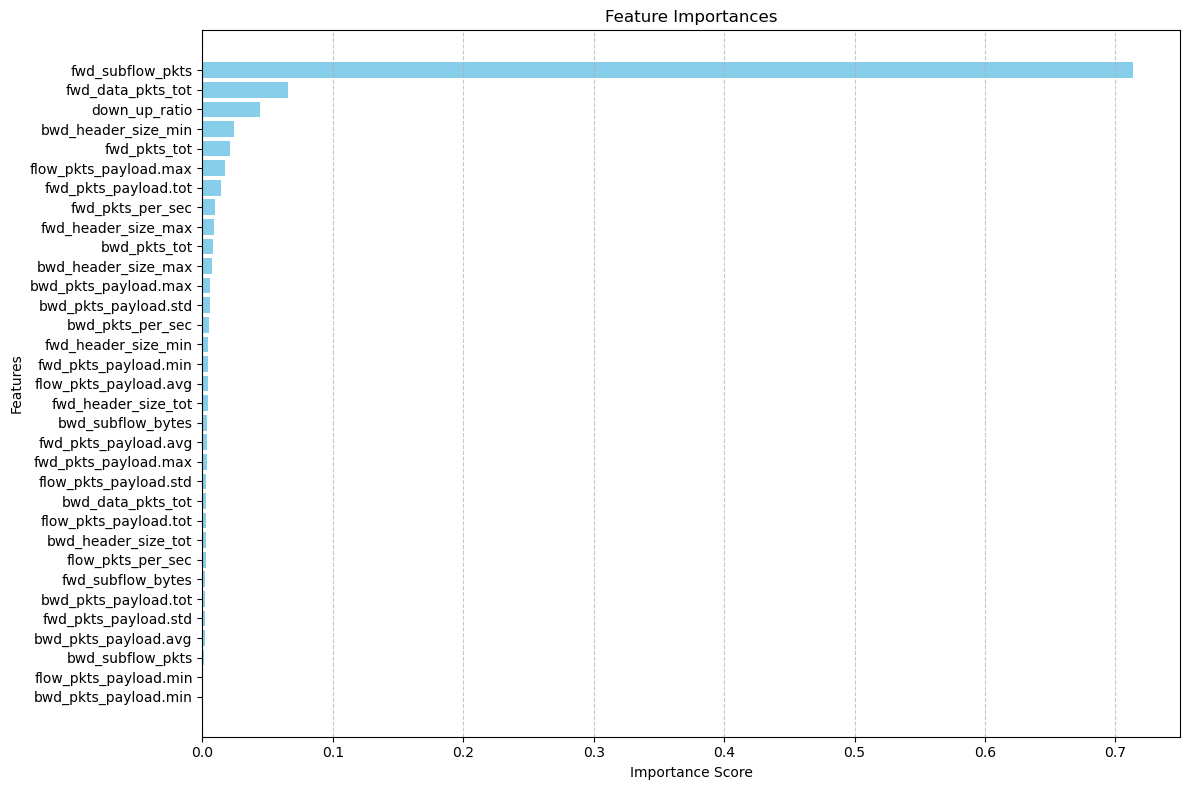

In [8]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

## Imodels

In [9]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: total: 0 ns
Wall time: 6.9 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,fwd_subflow_pkts,29,0.713770,1.000000
1,fwd_data_pkts_tot,2,0.065334,0.969697
2,down_up_ratio,7,0.044436,0.939394
3,bwd_header_size_min,12,0.024490,0.909091
4,fwd_pkts_tot,0,0.021313,0.878788
5,flow_pkts_payload.max,25,0.017007,0.848485
6,fwd_pkts_payload.tot,16,0.014155,0.818182
7,fwd_pkts_per_sec,4,0.009863,0.787879
8,fwd_header_size_max,10,0.008898,0.757576
9,bwd_pkts_tot,1,0.008019,0.727273


## Shap

In [10]:
#pip install shap

## InterpretML

In [11]:
#pip install interpret

In [12]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)
C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\SALib\util\__init__.py:302: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_group_names = pd.unique(groups)


CPU times: total: 3.55 s
Wall time: 361 ms
                              0
flow_pkts_payload.max  0.157545
bwd_pkts_payload.avg   0.123791
fwd_pkts_per_sec       0.111277
bwd_pkts_per_sec       0.109866
fwd_header_size_min    0.088669
flow_pkts_per_sec      0.077850
bwd_header_size_min    0.072167
fwd_pkts_payload.tot   0.067311
fwd_header_size_tot    0.060644
bwd_header_size_tot    0.059099
fwd_subflow_pkts       0.057842
down_up_ratio          0.056192
fwd_header_size_max    0.056110
fwd_pkts_payload.min   0.051889
fwd_pkts_payload.std   0.050086
bwd_pkts_payload.max   0.045899
fwd_data_pkts_tot      0.040664
bwd_pkts_payload.std   0.039771
bwd_header_size_max    0.039409
fwd_pkts_payload.max   0.037969
fwd_pkts_payload.avg   0.037402
flow_pkts_payload.tot  0.036554
flow_pkts_payload.std  0.035848
fwd_pkts_tot           0.032620
flow_pkts_payload.avg  0.031247
bwd_pkts_tot           0.023686
bwd_subflow_pkts       0.017514
fwd_subflow_bytes      0.016154
bwd_subflow_bytes      0.0111

<!-- http://127.0.0.1:7037/2872702068176/ -->

## LOFO

In [16]:
#pip install lofo-importance

In [17]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="is_attack", feature_names=feature_names)

importance

C:\Users\ivoafonsobispo\anaconda3\Lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 31
[LightGBM] [Inf

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Inf

[LightGBM] [Info] Number of positive: 3301, number of negative: 1433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697296 -> initscore=0.834455
[LightGBM] [Info] Start training from score 0.834455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3296, number of negative: 1438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696240 -> initscore=0.829456


[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464
[LightGBM] [Info] Start training from score 0.839464
[LightGBM] [Warning] N

[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2224
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2235
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


[LightGBM] [Info] Number of positive: 3273, number of negative: 1461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691381 -> initscore=0.806586
[LightGBM] [Info] Start training from score 0.806586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3306, number of negative: 1428
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 4734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.698352 -> initscore=0.839464


,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
6,flow_pkts_per_sec,0.000343,0.000411,-0.000284,0.000784,0.000251,0.000623
9,bwd_pkts_per_sec,0.000315,0.000375,0.000118,-0.000202,0.000646,0.000699
19,fwd_pkts_payload.tot,0.000288,0.000244,0.000415,0.000207,-0.000062,0.000592
15,bwd_subflow_pkts,0.000249,0.000364,0.000278,0.000712,-0.000308,0.000312
21,flow_pkts_payload.tot,0.000180,0.000196,-0.000018,0.000381,0.000371,-0.000014
30,fwd_header_size_min,0.000050,0.000320,0.000437,0.000265,-0.000380,-0.000121
1,fwd_pkts_payload.min,0.000019,0.000170,0.000057,0.000276,-0.000082,-0.000174
13,bwd_header_size_min,0.000009,0.000505,0.000164,0.000758,-0.000563,-0.000323
32,fwd_header_size_tot,0.000004,0.000479,0.000418,0.000484,-0.000687,-0.000198
2,bwd_pkts_payload.min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
